In [1]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager
from sklearn.preprocessing import StandardScaler

import warnings 

warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,563808,22432,WATERING CAN PINK BUNNY,6.0,8/19/2011 11:46,1.95,12626.0,Germany
1,561645,23166,MEDIUM CERAMIC TOP STORAGE JAR,12.0,7/28/2011 15:16,1.25,14911.0,EIRE
2,568651,20985,HEART CALCULATOR,12.0,9/28/2011 12:04,1.25,12362.0,Belgium


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [37]:
# 인보이스에 C가있는 
c_mask = df['InvoiceNo'].str[0] == 'C'

# Unitprice
c_unit_map = (
    df.loc[c_mask, ['StockCode','UnitPrice']]
      .groupby('StockCode')['UnitPrice']
      .mean()
      .to_dict()
)

# UnitPrice로 결측 채우기
df.loc[c_mask & df['UnitPrice'].isna() ,'UnitPrice'] = df.loc[c_mask & df['UnitPrice'].isna(),'StockCode'].map(c_unit_map)
df.loc[c_mask & df['UnitPrice'].isna() ,'UnitPrice'] = \
    df.loc[c_mask & df['UnitPrice'].isna() ,'UnitPrice'].fillna(df['UnitPrice'].mean())

# Quantity 
c_q_map = (
    df.loc[c_mask, ['StockCode','Quantity']]
      .groupby('StockCode')['Quantity']
      .mean()
      .to_dict()
)

df.loc[c_mask & df['Quantity'].isna() ,'Quantity'] = df.loc[c_mask & df['Quantity'].isna(), 'StockCode'].map(c_q_map)

In [56]:
# 인보이스에 C가 없는 
mask = df['InvoiceNo'].str[0] =='C'

# Unitprice dictionary
unit_map = (
    df.loc[~mask, ['StockCode','UnitPrice']].
        groupby('StockCode')['UnitPrice'].mean().to_dict()
)

df.loc[~mask & df['UnitPrice'].isna(), 'UnitPrice'] = df.loc[~mask & df['UnitPrice'].isna() ,'StockCode'].map(unit_map)
# 나머지는 평균으로 대체 
df.loc[~mask & df['UnitPrice'].isna(), 'UnitPrice'] \
    = df.loc[~mask & df['UnitPrice'].isna(), 'UnitPrice'].fillna(df['UnitPrice'].mean())
q_map = (
    df.loc[~mask, ['StockCode','Quantity']].
    groupby('StockCode')['Quantity'].mean().to_dict()
)

df.loc[~mask & df['Quantity'].isna(),'Quantity'] = df.loc[~mask & df['Quantity'].isna(),'StockCode'].map(q_map)

##### **문제2) 이상치 제거방법 및 제거 전후의 통계적인 방법을 포함하여 설명**

<Axes: >

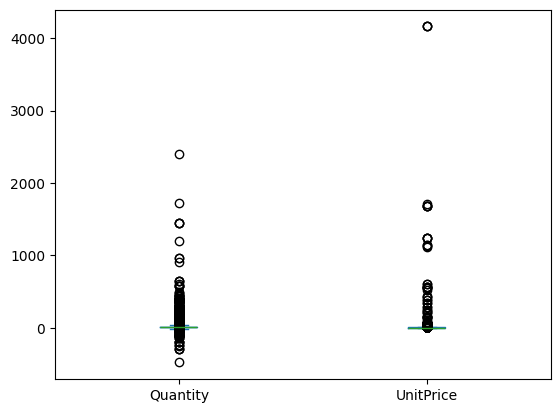

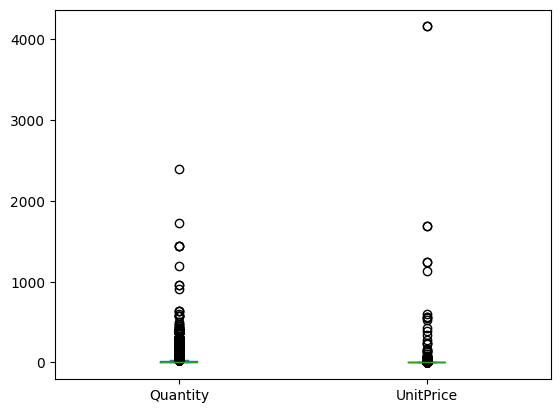

In [63]:
out_df = df.copy()

# Quantity와 UnitPrice의 이상치 확인 - 0이하의 숫자들이 있음 > 제거 
out_df[['Quantity','UnitPrice']].plot(kind = 'box') 

out_df[out_df['Quantity'] > 0][['Quantity','UnitPrice']].plot(kind = 'box')

##### **문제3) 각 StockCode을 기준으로 파생변수들을 만들고 제품들의 특성에 따른 군집 생성을 위한 전처리를 수행하라.**

In [83]:
# 1) InvoiceNo가 C가 아닌것들만 추출 
buy = df[df['InvoiceNo'].str[0] != 'C']
buy['price'] = buy['UnitPrice'] * buy['Quantity']

# 2) Country - StockCode별로 고유 나라의 개수 
t =  buy.groupby('StockCode', as_index = False).agg( 
                                                     n_countires = ('Country','nunique') , 
                                                     n_custoemrs = ('CustomerID','count') , 
                                                     mean_unit = ('UnitPrice','mean') , 
                                                     mean_qty = ('Quantity','mean') , 
                                                     mean_price = ('price','mean')  )
print(t.head())

  StockCode  n_countires  n_custoemrs  mean_unit   mean_qty  mean_price
0     10002            5           12   0.850000  35.083333   29.820833
1     10120            1            1   0.210000  10.000000    2.100000
2     10125            3           13   0.750769  46.923077   37.900000
3     10133            3            4   0.527500  17.500000    8.425000
4     10135            3            3   0.910000  90.000000   83.233333


In [90]:

# Scaling처리 
scaled_df = pd.DataFrame()
for col in t.columns : 
    if col != 'StockCode' :
        ss = StandardScaler()
        scaled_df[col] = ss.fit_transform(t[[col]]).flatten()
    else : 
        scaled_df[col] = t[col]

scaled_df.head(10)

,StockCode,n_countires,n_custoemrs,mean_unit,mean_qty,mean_price
0,10002,0.676164,-0.040673,-0.155350,0.479357,0.079975
1,10120,-1.180274,-0.447639,-0.193944,-0.229192,-0.746868
2,10125,-0.252055,-0.003676,-0.161334,0.813804,0.320956
3,10133,-0.252055,-0.336648,-0.174798,-0.017334,-0.558209
4,10135,-0.252055,-0.373645,-0.151732,2.030633,1.673136
5,11001,0.676164,-0.188660,-0.104696,-0.059706,-0.002970
6,15034,-0.716165,-0.410642,-0.198165,0.166277,-0.709286
7,15036,0.212055,0.107315,-0.158139,1.755217,0.965155
8,15039,-0.252055,-0.373645,-0.155350,-0.313936,-0.632032
9,15044A,-1.180274,-0.299651,-0.028714,-0.342184,-0.281559


##### **문제3.1) Kmeans , DBSCAN 방법 중 하나를 선택하여 군집분석을 시행하고 각 군집별 특성을 분석.**

In [95]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

k_df = scaled_df.set_index('StockCode')

<Axes: xlabel='PC_0', ylabel='PC_1'>

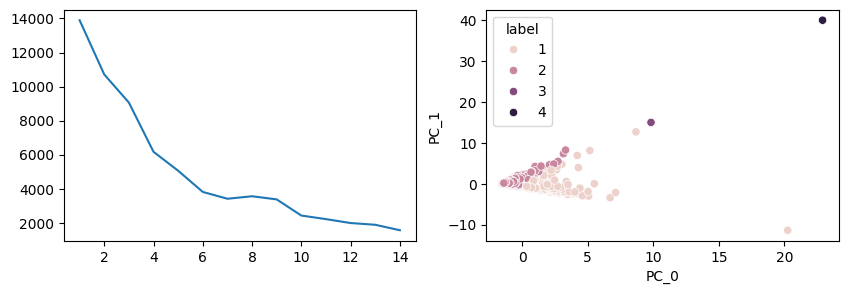

In [114]:
# scaled_df

iner = []
for k in range(1, 15) :
    km = KMeans(n_clusters= k, random_state = 42)
    km.fit(k_df)
    iner.append(km.inertia_)

fig, axes = plt.subplots(1,2, figsize = (10, 3))
sns.lineplot(x = range(1, 15) , y = iner, ax = axes[0])
# 경사가 완만해진 시점 = 4 

km4 = KMeans(n_clusters = 4, random_state = 42)
labels = km4.fit_predict(k_df) + 1
k_df['label'] = labels


# PCA 평면에 Label 뿌리기
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(k_df) , columns = ['PC_' + str(x) for x in range(k_df.shape[1])] )
pca_df['label'] = labels

sns.scatterplot(data = pca_df , x= pca_df['PC_0'] , y= pca_df['PC_1'] , hue = pca_df['label'] , ax = axes[1])

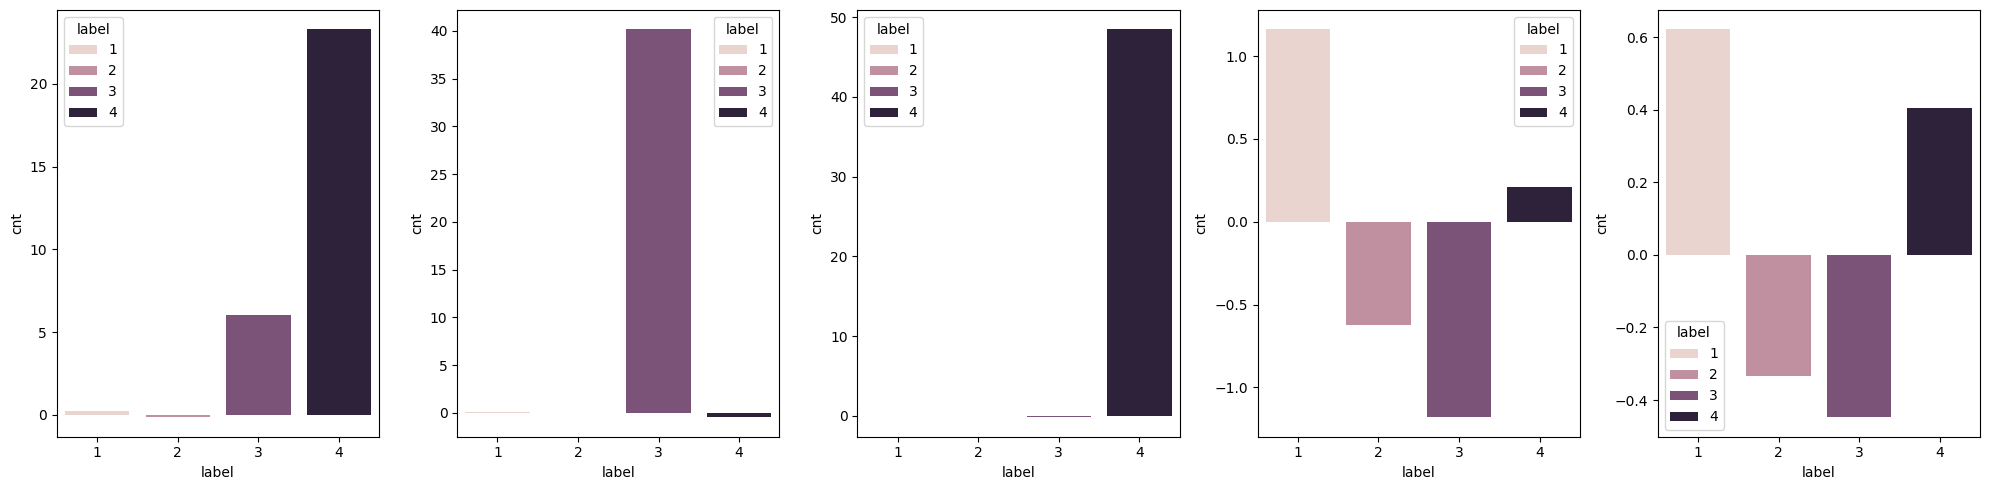

In [131]:
fig, axes = plt.subplots(1,5, figsize = (20,5))

for axes, col in zip(axes.flatten() , k_df.columns.difference(['label'])) : 
    target= k_df[['label',col]].groupby('label')[col].mean().reset_index(name = 'cnt')
    sns.barplot(data = target, x = target.label , y = target.cnt ,hue = target.label , ax = axes)

plt.tight_layout()
plt.show()

##### **통계1)**
제품 불량률을 조사하려고 한다. 이 회사의 제품 불량률이 실제로는 90%.  추정된 불량률의 추정오차한계가 5% 이내가 되도록 하려면, 어느 정도의 표본 크기가 필요한지 계산

In [135]:
from scipy.stats import norm
p = 0.9 

ME = 0.05

z_confa = norm.ppf(1 - 0.05/2)

size = (z_confa**2 * p * (1-p)) / ME **2 
size

np.float64(138.29251754498844)

##### **통계2)**
은의 가격 및 이동평균값 3이 설정된 시계열 그래프

In [143]:
lst = [12.14,42.6,34.4,35.29,30.96,57.12,37.84,42.49,31.38]
df = pd.DataFrame(lst,columns =['data'])

df['month'] = [str(k) + '월' for k in range(1, 10)]
df.head()

,data,month
0,12.14,1월
1,42.60,2월
2,34.40,3월
3,35.29,4월
4,30.96,5월


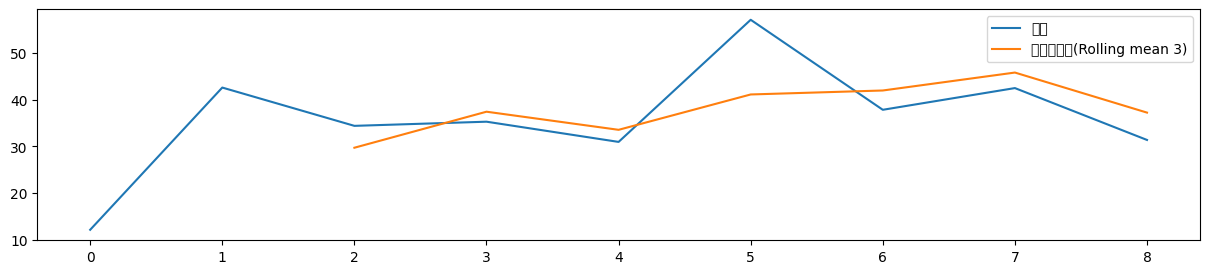

In [148]:
df['rolling_3']= df['data'].rolling(3).mean()

fig, axes = plt.subplots(1, figsize = (15,3))
plt.plot(df['data'], label = '원본')
plt.plot(df['rolling_3'] , label = '이동평균값(Rolling mean 3)')
plt.legend()
plt.show()

In [171]:
#1월 대비 9월의 은의 가격은 몇 % 올랐는가? 소수점 두번째 자리에서 반올림
jan = df.loc[df['month'] == '1월','data'].values
sep = df.loc[df['month'] == '9월','data'].values

(sep - jan )/ jan * 100

array([158.48434926])

##### **통계3)**

In [206]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/pressure.csv')
df.head()

,gender,pressure
0,male,106.8
1,male,100.8
2,male,84.5
3,male,104.2
4,male,107.0


In [207]:
from scipy.stats import shapiro , mannwhitneyu

# 1) 정규성 검토 
res = []
for key, group in df.groupby('gender') : 
    g = group['pressure']
    stat, p_val = shapiro(g)
    res.append({
        'Columns' : key, 
        'P_value' : p_val, 
        'Decision' : '정규분포가 아니다' if p_val < 0.05 else '정규분포'
    })
    

pd.DataFrame(res) 

group = [group['pressure'] for name, group in df.groupby('gender')]
stat, p_val = mannwhitneyu(group[0], group[1])
print(p_val)

#h0: 성별에 따른 pressure의 차이는 없다
#h1: 성별에 따른 pressure의 차이가 있다. 


0.14875840681321661


##### **통계4)** 
6.2의 검정 통계량 값을 바탕으로 신뢰수준 95%하에서 신뢰구간을 설정

In [208]:
from scipy.stats import t 
import numpy as np
confa = 0.95 

m = df.loc[df['gender'] =='male']['pressure']
mn = len(m)
m_var = np.var(m, ddof = 1)


f = df.loc[df['gender'] =='female']['pressure']
fn = len(f)
f_var = np.var(f, ddof = 1)


In [210]:
# 자유도 
df = mn + fn - 2
# t_confa 
t_confa = t.ppf(1 - 0.05 /2 ,df) 

# se : 중요
se = np.sqrt(m_var / mn + f_var / fn)

# mean_diff
diff = m.mean() - f.mean() 

# ME
ME = t_confa * se 

print(diff - ME, diff + ME)

-2.2236553334945324 14.838933111272338
